In [3]:
import mdtraj as md
import numpy as np
import os
from Bio import pairwise2

protein='Tyrosine Kinase'

pdb_GS='active'
pdb_FS='inactive'


In [4]:
def get_traj(folder):
    """
    Loads PDB files from a specified folder, sorts them by the number in their filenames,
    and concatenates them into a single trajectory.

    Parameters:
        folder (str): The path to the folder containing the 'clusX.pdb' files.

    Returns:
        mdtraj.Trajectory: The concatenated trajectory.
    """
    clusters = []

    # Sort filenames numerically based on the number after 'clus'
    def extract_cluster_number(filename):
        # Extract the number part from 'clusX.pdb'
        return int(filename[4:-4])

    # Get the sorted list of filenames
    sorted_filenames = sorted(
        [f for f in os.listdir(folder) if f.startswith('clus') and f.endswith('.pdb')],
        key=extract_cluster_number
    )

    # Load each cluster and append it to the clusters list
    for filename in sorted_filenames:
        cluster = md.load(os.path.join(folder, filename))
        clusters.append(cluster)

    # Concatenate all clusters into a single trajectory
    trajectory = clusters[0]
    for cluster in clusters[1:]:
        trajectory += cluster

    return trajectory

In [6]:
fullMSA=md.load('results/fullMSA_noH.pdb')
GS=md.load(pdb_GS+'.pdb')
FS=md.load(pdb_FS+'.pdb')

In [7]:
backbone_GS=[]
backbone_FS=[]
backbone_ref=[]
app=[]



# Dictionary to map three-letter codes to one-letter codes
three_to_one = {
    "ALA": "A", "ARG": "R", "ASN": "N", "ASP": "D", "CYS": "C",
    "GLU": "E", "GLN": "Q", "GLY": "G", "HIS": "H", "ILE": "I",
    "LEU": "L", "LYS": "K", "MET": "M", "PHE": "F", "PRO": "P",
    "SER": "S", "THR": "T", "TRP": "W", "TYR": "Y", "VAL": "V"
}


with open('results/fullMSA_noH.pdb', 'r') as file:
    for index, line in enumerate(file):
        columns = line.strip().split()
        if len(columns) >= 4 and (columns[2] == "C"):
            backbone_ref.append(index+1)
            app.append(columns[3])
res_ref= "".join([three_to_one[aa] for aa in app])
app=[]
  

with open(pdb_GS+'.pdb', 'r') as file:
    for index, line in enumerate(file):
        columns = line.strip().split()
        if len(columns) >= 4 and (columns[2] == "C"):
            backbone_GS.append(index+1)
            app.append(columns[3])
            
res_GS= "".join([three_to_one[aa] for aa in app])
app=[]      

with open(pdb_FS+'.pdb', 'r') as file:
    for index, line in enumerate(file):
        columns = line.strip().split()
        if len(columns) >= 4 and (columns[2] == "C"):
            backbone_FS.append(index+1)
            app.append(columns[3])
            
res_FS= "".join([three_to_one[aa] for aa in app])

In [8]:
alignments = pairwise2.align.globalxx(res_ref, res_GS)
ind_GS = [index for index, char in enumerate(alignments[0][1]) if char != '-']

alignments = pairwise2.align.globalxx(res_ref, res_FS)
ind_FS = [(index-1) for index, char in enumerate(alignments[0][1]) if char != '-']

In [9]:
rmsd_full_GS = md.rmsd(fullMSA, GS, atom_indices=np.array(backbone_ref), ref_atom_indices=np.array(backbone_GS))
rmsd_full_FS=md.rmsd(fullMSA, FS, atom_indices=np.array(backbone_ref), ref_atom_indices=np.array(backbone_FS))

In [10]:
def plot_states(rmsd_GS, rmsd_FS, plddt, cl_size, th_GS, th_FS):

    plt.title(protein+' - '+method, fontsize=22)
    sc = plt.scatter(rmsd_GS * 10, rmsd_FS * 10, c=plddt, cmap='rainbow_r', vmin=50, vmax=90, s=cl_size*3, alpha=0.6)
    cbar = plt.colorbar(sc, label='plDDT')  # Create colorbar and set label

    # Set font size for colorbar label
    cbar.ax.yaxis.label.set_fontsize(20)

    # Plotting a different marker for a specific point
    plt.scatter(rmsd_full_GS * 10, rmsd_full_FS * 10, marker='*', s=300, label='fullMSA', color='black')

    for i, (x, y) in enumerate(zip(rmsd_GS * 10, rmsd_FS * 10)):
        plt.text(x, y, str(i+1), fontsize=10, ha='center', va='center', color='black')
    # Adding dashed lines
    plt.axhline(y=th_FS*10, color='black', linestyle='--')
    plt.axvline(x=th_GS*10, color='black', linestyle='--')

    # Setting limits and ticks for both axes
    #plt.xlim([0, 23])
    #plt.ylim([7, 22])
    #plt.xticks([5,10,15,20], fontsize=22)
    #plt.yticks([10,15,20], fontsize=22)

        # Adding labels and legend
    plt.xlabel('RMSD to '+pdb_GS+' (A°)', fontsize=20)
    plt.ylabel('RMSD to '+pdb_FS+' (A°)', fontsize=20)
    #plt.legend(fontsize=15)

    plt.show()
    return()

In [11]:
folder='results'
trajectory=get_traj(folder)
plddt = np.load(folder+'/plddt.npy')
cl_size = np.load(folder+'/size.npy')

rmsd_GS = md.rmsd(trajectory, GS, atom_indices=np.array(backbone_ref), ref_atom_indices=np.array(backbone_GS))
rmsd_FS = md.rmsd(trajectory, FS, atom_indices=np.array(backbone_ref), ref_atom_indices=np.array(backbone_FS))

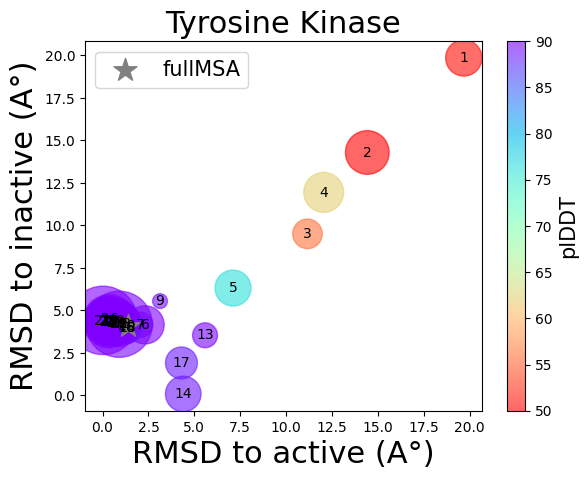

In [12]:
import matplotlib.pyplot as plt

plt.title(protein, fontsize=22)
sc = plt.scatter(rmsd_GS * 10, rmsd_FS * 10, c=plddt, cmap='rainbow_r', vmin=50, vmax=90, s=cl_size*3, alpha=0.6)
cbar = plt.colorbar(sc, label='plDDT')  # Create colorbar and set label

# Set font size for colorbar label
cbar.ax.yaxis.label.set_fontsize(15)

# Plotting a different marker for a specific point
plt.scatter(rmsd_full_GS * 10, rmsd_full_FS * 10, marker='*', s=300, label='fullMSA', color='grey')

for i, (x, y) in enumerate(zip(rmsd_GS * 10, rmsd_FS * 10)):
    plt.text(x, y, str(i+1), fontsize=10, ha='center', va='center', color='black')

# Adding dashed lines
#plt.axhline(y=4, color='black', linestyle='--')
#plt.axvline(x=4, color='black', linestyle='--')

# Setting limits and ticks for both axes
#plt.xlim([0, 23])
#plt.ylim([7, 22])
#plt.xticks([4,8,12,16], fontsize=22)
#plt.yticks([4,8,12,16], fontsize=22)

# Adding labels and legend
plt.xlabel('RMSD to '+pdb_GS+' (A°)', fontsize=22)
plt.ylabel('RMSD to '+pdb_FS+' (A°)', fontsize=22)
plt.legend(fontsize=15)

plt.show()

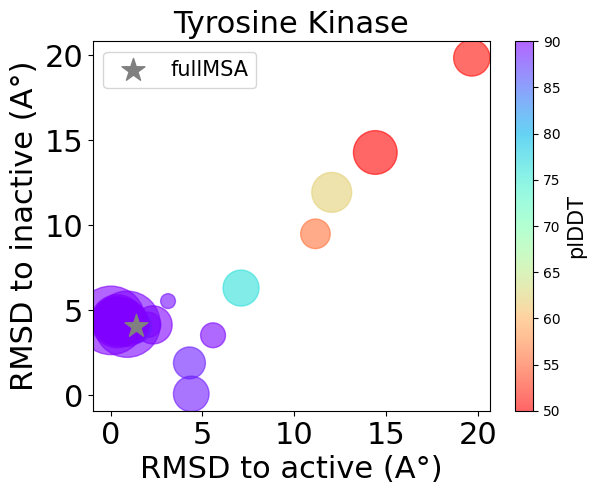

In [13]:
plt.title(protein, fontsize=22)
sc = plt.scatter(rmsd_GS * 10, rmsd_FS * 10, c=plddt, cmap='rainbow_r', vmin=50, vmax=90, s=cl_size*3, alpha=0.6)
cbar = plt.colorbar(sc, label='plDDT')  # Create colorbar and set label

# Set font size for colorbar label
cbar.ax.yaxis.label.set_fontsize(15)

# Plotting a different marker for a specific point
plt.scatter(rmsd_full_GS * 10, rmsd_full_FS * 10, marker='*', s=300, label='fullMSA', color='grey')


# Adding dashed lines
#plt.axhline(y=4, color='black', linestyle='--')
#plt.axvline(x=4, color='black', linestyle='--')

# Setting limits and ticks for both axes
#plt.xlim([0, 23])
#plt.ylim([7, 22])
plt.xticks([0,5,10,15, 20], fontsize=22)
plt.yticks([0,5,10,15, 20], fontsize=22)

# Adding labels and legend
plt.xlabel('RMSD to '+pdb_GS+' (A°)', fontsize=22)
plt.ylabel('RMSD to '+pdb_FS+' (A°)', fontsize=22)
plt.legend(fontsize=15)
plt.savefig('2drmad_plot_Kinase.png', bbox_inches='tight', pad_inches=0.5)

plt.show()

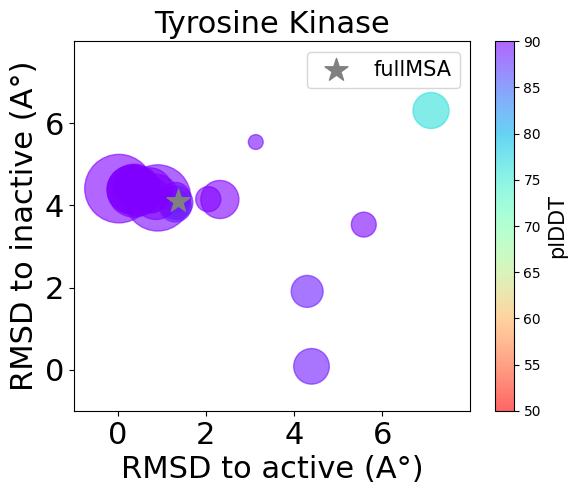

In [14]:
plt.title(protein, fontsize=22)
sc = plt.scatter(rmsd_GS * 10, rmsd_FS * 10, c=plddt, cmap='rainbow_r', vmin=50, vmax=90, s=cl_size*3, alpha=0.6)
cbar = plt.colorbar(sc, label='plDDT')  # Create colorbar and set label

# Set font size for colorbar label
cbar.ax.yaxis.label.set_fontsize(15)

# Plotting a different marker for a specific point
plt.scatter(rmsd_full_GS * 10, rmsd_full_FS * 10, marker='*', s=300, label='fullMSA', color='grey')

# Adding dashed lines
#plt.axhline(y=4, color='black', linestyle='--')
#plt.axvline(x=4, color='black', linestyle='--')

# Setting limits and ticks for both axes
plt.xlim([-1, 8])
plt.ylim([-1, 8])
plt.xticks([0,2,4,6], fontsize=22)
plt.yticks([0,2,4,6], fontsize=22)

# Adding labels and legend
plt.xlabel('RMSD to '+pdb_GS+' (A°)', fontsize=22)
plt.ylabel('RMSD to '+pdb_FS+' (A°)', fontsize=22)
plt.legend(fontsize=15)
plt.savefig('2drmad_plot_Kinase_zoom.png', bbox_inches='tight', pad_inches=0.5)
plt.show()

In [15]:
np.where(rmsd_GS<0.4)

(array([ 5,  6,  7,  8,  9, 10, 11, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24,
        25, 26, 27, 28]),)

In [16]:
np.where(rmsd_FS<0.38)

(array([12, 13, 16]),)

In [17]:
np.where((rmsd_GS>0.4) & (rmsd_FS>0.38))

(array([0, 1, 2, 3, 4]),)

In [18]:
np.save('results/cluster_ids_fullMSA_state',np.where(rmsd_GS<0.4)[0]+1)
np.save('results/cluster_ids_alternative_state',np.where(rmsd_FS<0.38)[0]+1)